In [23]:
'''
use K-means algorithm to cluster Fossil Insect dataset
by: https://github.com/jackhuntcn/notebooks/blob/master/autoencoder_and_clustering.ipynb
'''
import os
import sys
sys.path.append('.')

import cv2
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.rcParams['font.size'] = 8
plt.rcParams['figure.figsize'] = (8, 8)

from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.preprocessing.image import load_img, img_to_array
from keras import backend as K

from sklearn.cluster import KMeans

In [10]:
# model base config
IMG_WIDTH, IMG_HEIGHT, CHANNELS = 128, 128, 3
input_shape = (IMG_WIDTH, IMG_HEIGHT, CHANNELS)

TARGET_DIR = '/Users/xie/Code/paleontology_fossil_ocr/data/resized_dataset/Fossil_Insect'

In [7]:
# load dataset file into numpy array
dataset = [os.path.join(TARGET_DIR, file) for file in os.listdir(TARGET_DIR)]
ds_arr = np.empty((len(dataset), IMG_WIDTH, IMG_HEIGHT, CHANNELS), dtype=np.float32)

for index, file in enumerate(dataset):
    img = load_img(file)
    img_arr = img_to_array(img).reshape(IMG_WIDTH, IMG_HEIGHT, CHANNELS)
    ds_arr[index] = img_arr.astype('float32') / 255.

print(ds_arr.shape)

(715, 128, 128, 3)


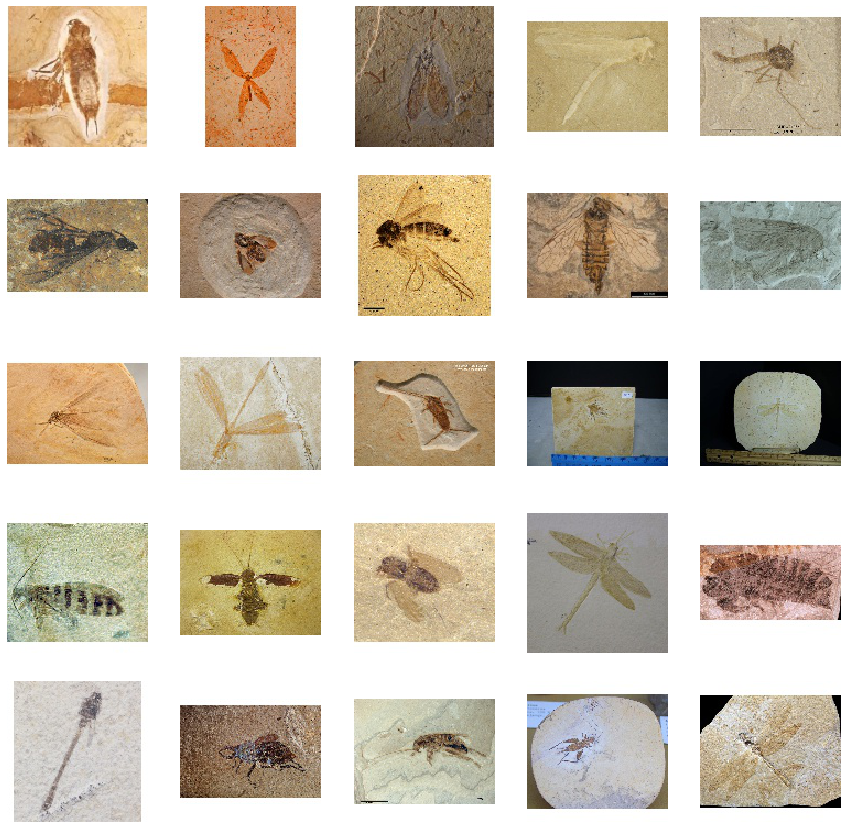

In [9]:
# show part of images
nb_rows, nb_cols = 5, 5
plt.figure(figsize=(15, 15))
for i in range(nb_rows * nb_cols):
    plt.subplot(nb_rows, nb_cols, i + 1)
    plt.imshow(ds_arr[i])
    plt.axis('off')

In [46]:
# autoencoder model
# encoder part(conv + relu + maxpooling)
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape, padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Conv2D(8, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# decoder part(conv + relu + upsampling) * 3, contrary to encoder part
model.add(Conv2D(8, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(3, kernel_size=(3, 3), activation='sigmoid', padding='same'))

model.compile(loss='binary_crossentropy', optimizer='adadelta', metrics=['accuracy'])

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 64, 64, 16)        4624      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 32, 32, 16)        2320      
_________________________________________________________________
up_sampling2d_7 (UpSampling2 (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 64, 64, 32)       

In [47]:
model.fit(ds_arr, ds_arr, epochs=20, batch_size=128, shuffle=True)

Epoch 1/20
715/715 [==============================] - 30s 42ms/step - loss: 0.6455 - accuracy: 0.1685
Epoch 2/20
715/715 [==============================] - 30s 41ms/step - loss: 0.5891 - accuracy: 0.2133
Epoch 3/20
715/715 [==============================] - 29s 41ms/step - loss: 0.5922 - accuracy: 0.2133
Epoch 4/20
715/715 [==============================] - 29s 41ms/step - loss: 0.5936 - accuracy: 0.2134
Epoch 5/20
715/715 [==============================] - 29s 41ms/step - loss: 0.5835 - accuracy: 0.2143
Epoch 6/20
715/715 [==============================] - 29s 41ms/step - loss: 0.5857 - accuracy: 0.2143
Epoch 7/20
715/715 [==============================] - 29s 41ms/step - loss: 0.5693 - accuracy: 0.2147
Epoch 8/20
715/715 [==============================] - 371s 519ms/step - loss: 0.5937 - accuracy: 0.2033
Epoch 9/20
715/715 [==============================] - 30s 42ms/step - loss: 0.5886 - accuracy: 0.2078
Epoch 10/20
715/715 [==============================] - 30s 42ms/step - loss: 0.5

Before autoencode:


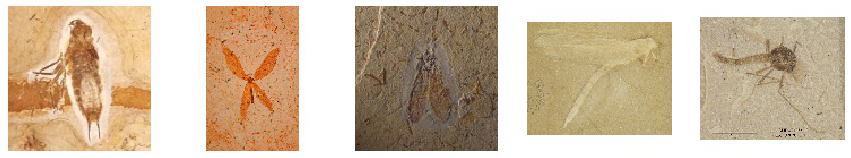

After autoencode:


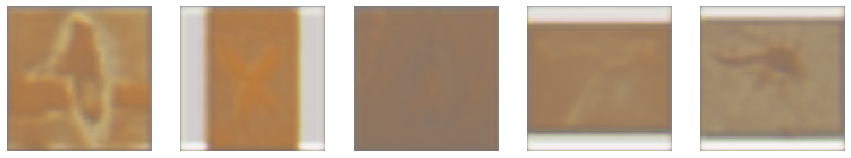

In [50]:
# check result of autoencoder
def plot_images(im_list):
    plt.figure(figsize=(15, 4))
    for index, array in enumerate(im_list):
        plt.subplot(1, len(im_list), index + 1)
        plt.imshow(array)
        plt.axis('off')
    plt.show()

img_decoded = model.predict(ds_arr[:5])
print('Before autoencode:')
plot_images(ds_arr[:5])
print('After autoencode:')
plot_images(img_decoded)

In [51]:
ds_sample = ds_arr[:100]
print(ds_sample.shape)

(100, 128, 128, 3)


In [52]:
# get the encoder part of autoencode model
get_encoded = K.function([model.layers[0].input], [model.layers[5].output])
encoded_sample = get_encoded([ds_sample])[0]

print(encoded_sample.shape)

(100, 64, 64, 16)


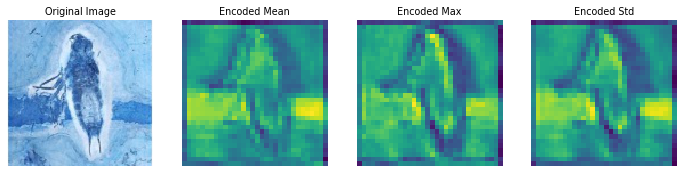

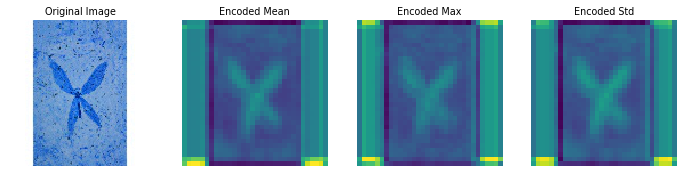

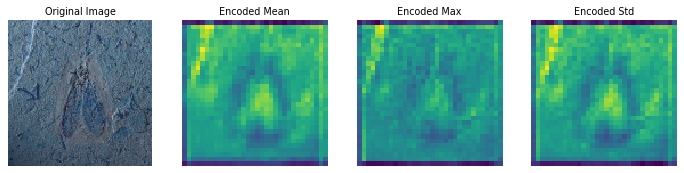

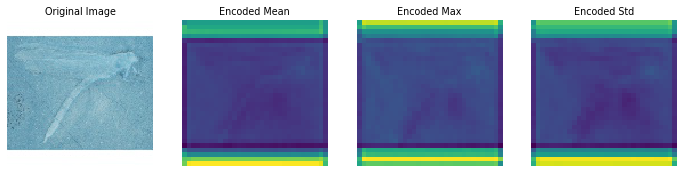

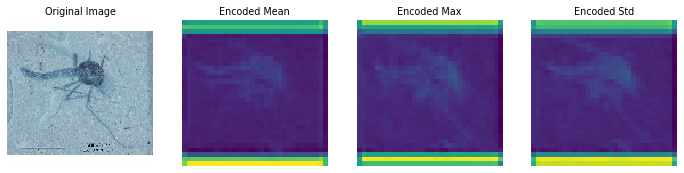

In [53]:
# show result after encode
# the shape after encoding is (16, 16, 8), so display in mean, max, std dimension separately
for n_image in range(0, 5):
    
    plt.figure(figsize=(12,4))

    plt.subplot(1,4,1)
    plt.imshow(ds_sample[n_image][:,:,::-1])
    plt.axis('off')
    plt.title('Original Image')

    plt.subplot(1,4,2)
    plt.imshow(encoded_sample[n_image].mean(axis=-1))
    plt.axis('off')
    plt.title('Encoded Mean')

    plt.subplot(1,4,3)
    plt.imshow(encoded_sample[n_image].max(axis=-1))
    plt.axis('off')
    plt.title('Encoded Max')

    plt.subplot(1,4,4)
    plt.imshow(encoded_sample[n_image].std(axis=-1))
    plt.axis('off')
    plt.title('Encoded Std')

    plt.show()

In [54]:
# the shape of dataset after encoding
ds_encoded = np.empty((len(ds_arr), 16, 16, 8), dtype='float32')

step = 100
for i in range(0, len(ds_arr), step):
    ds_batch = get_encoded([ds_arr[i: i + step]])[0]
    ds_encoded[i:i+step] = ds_batch

print(ds_encoded.shape)

ValueError: could not broadcast input array from shape (100,64,64,16) into shape (100,16,16,8)

In [31]:
# reshape, equal to flatten in NN, and feed to KMeans
ds_encoded_reshape = ds_encoded.reshape(ds_encoded.shape[0], ds_encoded.shape[1] * ds_encoded.shape[2] * ds_encoded.shape[3])
print(ds_encoded_reshape.shape)

(715, 2048)


In [32]:
# KMeans cluster
n_clusters = 100

km = KMeans(n_clusters=n_clusters)
km.fit(ds_encoded_reshape)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=100, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

<BarContainer object of 100 artists>

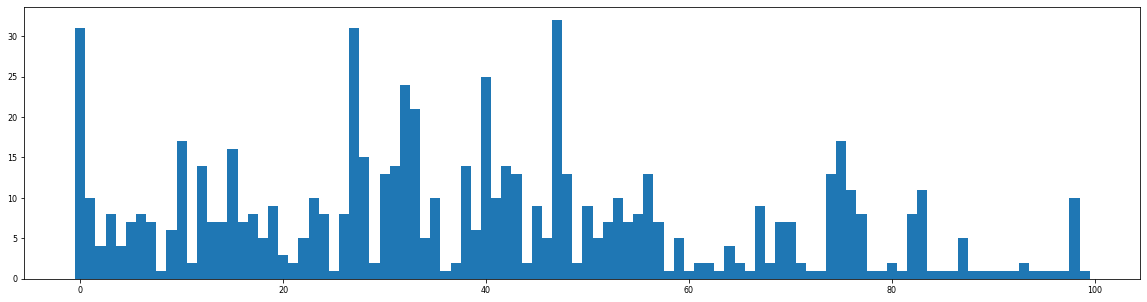

In [33]:
# distribution results of each cluster
plt.figure(figsize=(20, 5))
cluster_elements = [(km.labels_==i).sum() for i in range(n_clusters)]
plt.bar(range(n_clusters), cluster_elements, width=1)

In [34]:
# the average encoded value of each cluster
average_clusters_encoded = []
for i in range(n_clusters):
    average_clusters_encoded.append(ds_encoded[km.labels_==i].mean(axis=0))

average_clusters_encoded = np.asarray(average_clusters_encoded)

print(average_clusters_encoded.shape)

(100, 16, 16, 8)


In [35]:
# get the decoder part of autoencode model

get_decoded = K.function([model.layers[6].input],
                         [model.layers[-1].output])

# average decoded image
decoded_clusters = get_decoded([average_clusters_encoded])

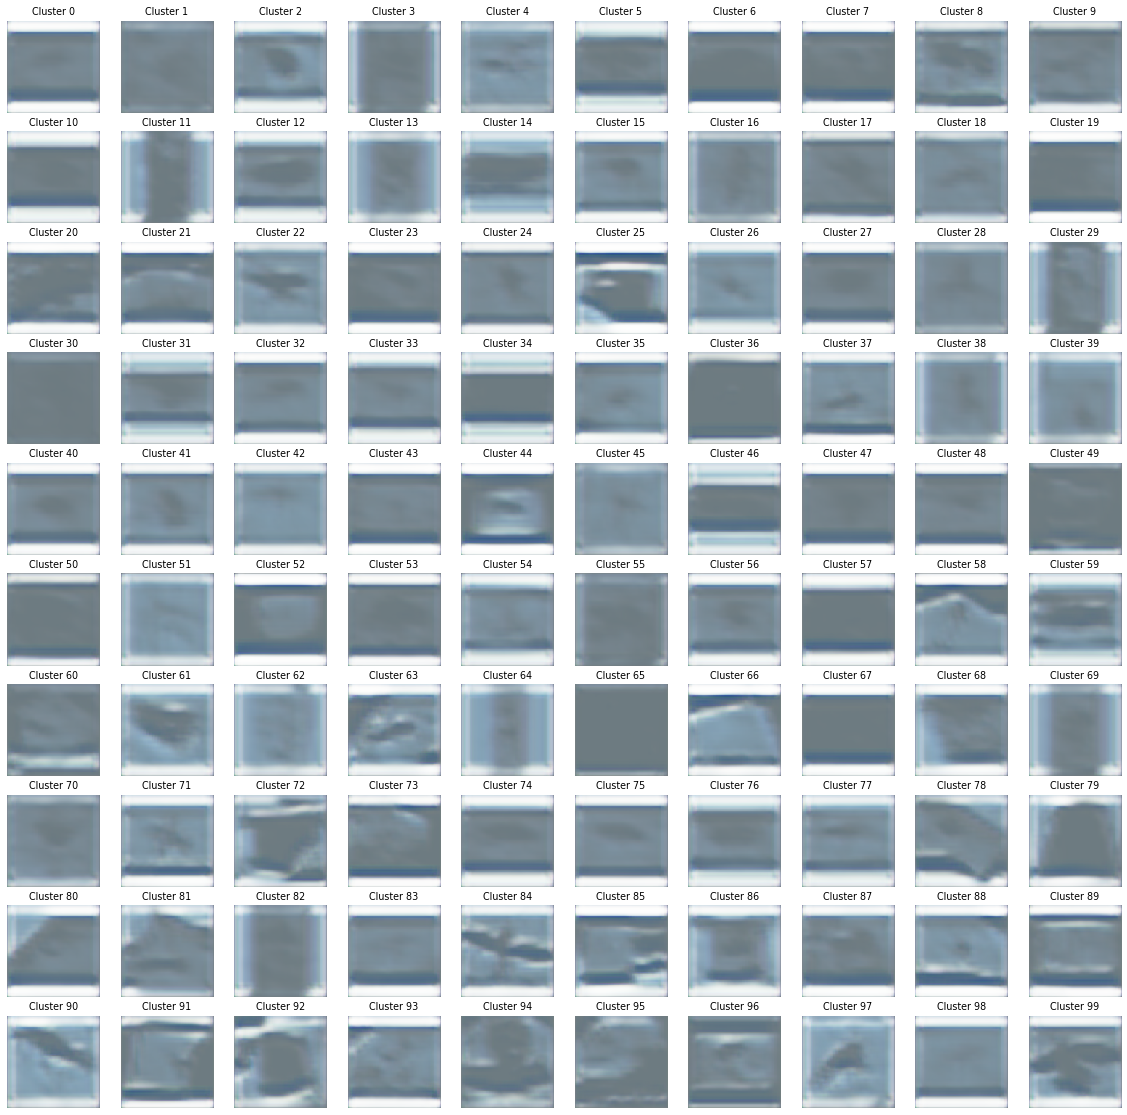

In [36]:
# show the average decode image of each cluster
plt.figure(figsize=(20, 20))

for i in range(n_clusters):
    plt.subplot(10, 10, i+1)
    plt.imshow(decoded_clusters[0][i][:,:,::-1])
    plt.title('Cluster {}'.format(i))
    plt.axis('off')

plt.show()

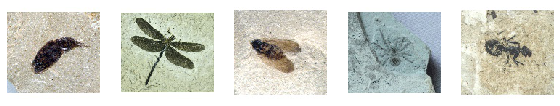

In [45]:
# take obviously cluster and display
plt.figure(figsize=(20, 20))

cluster = 22
rows, cols = 10, 10
start = 0

labels = np.where(km.labels_==cluster)[0][start:start+rows*cols]
for i, label in enumerate(labels):
    plt.subplot(rows, cols, i+1)
    plt.imshow(ds_arr[label])
    plt.axis('off')

In [48]:
# save cluster result
# pickle.dump(km, open('km_encoded.sav', 'wb'))

In [49]:
# get output of autoencoder's each layer
get_1st_layer  = K.function([model.layers[0].input], [model.layers[0].output])
get_2nd_layer  = K.function([model.layers[0].input], [model.layers[1].output])
get_3rd_layer  = K.function([model.layers[0].input], [model.layers[2].output])
get_4th_layer  = K.function([model.layers[0].input], [model.layers[3].output])
get_5th_layer  = K.function([model.layers[0].input], [model.layers[4].output])
get_6th_layer  = K.function([model.layers[0].input], [model.layers[5].output])
get_7th_layer  = K.function([model.layers[0].input], [model.layers[6].output])
get_8th_layer  = K.function([model.layers[0].input], [model.layers[7].output])
get_9th_layer  = K.function([model.layers[0].input], [model.layers[8].output])
get_10th_layer = K.function([model.layers[0].input], [model.layers[9].output])
get_11th_layer = K.function([model.layers[0].input], [model.layers[10].output])

sample_layer_1  = get_1st_layer([ds_sample])[0]
sample_layer_2  = get_2nd_layer([ds_sample])[0]
sample_layer_3  = get_3rd_layer([ds_sample])[0]
sample_layer_4  = get_4th_layer([ds_sample])[0]
sample_layer_5  = get_5th_layer([ds_sample])[0]
sample_layer_6  = get_6th_layer([ds_sample])[0]
sample_layer_7  = get_7th_layer([ds_sample])[0]
sample_layer_8  = get_8th_layer([ds_sample])[0]
sample_layer_9  = get_9th_layer([ds_sample])[0]
sample_layer_10 = get_10th_layer([ds_sample])[0]
sample_layer_11 = get_11th_layer([ds_sample])[0]
img_decoded = model.predict(ds_sample)

IndexError: list index out of range

In [ ]:
# print images of middle layer
for n_image in range(0, 10):
    
    plt.figure(figsize=(16,8))

    plt.subplot(1,13,1)
    plt.imshow(ds_sample[n_image].max(axis=-1))
    plt.axis('off')

    plt.subplot(1,13,2)
    plt.imshow(sample_layer_1[n_image].max(axis=-1))
    plt.axis('off')

    plt.subplot(1,13,3)
    plt.imshow(sample_layer_2[n_image].max(axis=-1))
    plt.axis('off')

    plt.subplot(1,13,4)
    plt.imshow(sample_layer_3[n_image].max(axis=-1))
    plt.axis('off')

    plt.subplot(1,13,5)
    plt.imshow(sample_layer_4[n_image].max(axis=-1))
    plt.axis('off')
    
    plt.subplot(1,13,6)
    plt.imshow(sample_layer_5[n_image].max(axis=-1))
    plt.axis('off')
    
    plt.subplot(1,13,7)
    plt.imshow(sample_layer_6[n_image].max(axis=-1))
    plt.axis('off')

    plt.subplot(1,13,8)
    plt.imshow(sample_layer_7[n_image].max(axis=-1))
    plt.axis('off')
    
    plt.subplot(1,13,9)
    plt.imshow(sample_layer_8[n_image].max(axis=-1))
    plt.axis('off')
    
    plt.subplot(1,13,10)
    plt.imshow(sample_layer_9[n_image].max(axis=-1))
    plt.axis('off')
    
    plt.subplot(1,13,11)
    plt.imshow(sample_layer_10[n_image].max(axis=-1))
    plt.axis('off')
    
    plt.subplot(1,13,12)
    plt.imshow(sample_layer_11[n_image].max(axis=-1))
    plt.axis('off')
    
    plt.subplot(1,13,13)
    plt.imshow(img_decoded[n_image].max(axis=-1))
    plt.axis('off')
    
    plt.show()